<a id="there_you_go"></a>
# Downloading Datasets:

In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mahdilb","key":"2d2ee6dbf9588cdf971c1f8346a62b5d"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

ref                                                         title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
AnalyzeBoston/crimes-in-boston                              Crimes in Boston                                     10MB  2018-09-04 17:56:03           2515  
new-york-city/new-york-city-current-job-postings            New York City Current Job Postings                    3MB  2019-07-14 22:06:11           3325  
jealousleopard/goodreadsbooks                               Goodreads-books                                     632KB  2019-06-14 16:35:05           3689  
sudalairajkumar/chennai-water-management                    Chennai Water Management                             75KB  2019-06-19 03:42:44           3014  
r3w0p4/bournemouth-venues                                   Venu

In [3]:
!kaggle datasets download -d sengzhaotoo/movielens-small

  0% 0.00/910k [00:00<?, ?B/s]
100% 910k/910k [00:00<00:00, 60.1MB/s]


In [4]:
!unzip movielens-small.zip

Archive:  movielens-small.zip
  inflating: ratings.csv             
  inflating: tags.csv                
  inflating: links.csv               
  inflating: movies.csv              
  inflating: README.txt              


# Libraries:

In [5]:
import numpy as np
import pandas as pd
import pickle
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import math 
import itertools
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error 
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Embedding, Input, dot, concatenate, merge
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Reshape
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping, ModelCheckpoint
from sklearn.neighbors import NearestNeighbors
from keras.utils import to_categorical
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import missingno as msno
from wordcloud import WordCloud
%matplotlib inline
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)

Using TensorFlow backend.


# Reading Data and the pre analysis:

In [6]:
rates = pd.read_csv('ratings.csv')
# we do not care when the user rated the particular movie!
rates.drop(['timestamp'], axis=1, inplace=True)
print('table of rates : (rows, features): ',rates.shape)
movies = pd.read_csv('movies.csv')
print('table of movies : (rows, features): ',movies.shape)
rates.head()

table of rates : (rows, features):  (100004, 3)
table of movies : (rows, features):  (9125, 3)


,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [7]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
users = rates.userId.unique()
user_map = {i:val for i,val in enumerate(users)}
inverse_user_map = {val:i for i,val in enumerate(users)}
Movies = rates.movieId.unique()
movie_map = {i:val for i,val in enumerate(Movies)}
inverse_movie_map = {val:i for i,val in enumerate(Movies)}

print("We have %d users"%users.shape[0])
print("We have %d movies"%Movies.shape[0])

We have 671 users
We have 9066 movies


In [9]:
rates.describe()

,userId,movieId,rating
count,100004.000000,100004.000000,100004.000000
mean,347.011310,12548.664363,3.543608
std,195.163838,26369.198969,1.058064
min,1.000000,1.000000,0.500000
25%,182.000000,1028.000000,3.000000
50%,367.000000,2406.500000,4.000000
75%,520.000000,5418.000000,4.000000
max,671.000000,163949.000000,5.000000


In [10]:
ratings_df = rates.groupby(['userId','movieId']).aggregate(np.max)
print(len(ratings_df))
if (len(ratings_df) == rates.shape[0]):
  print("there are no such cases where the user has rated the same movie twice.")

100004
there are no such cases where the user has rated the same movie twice.


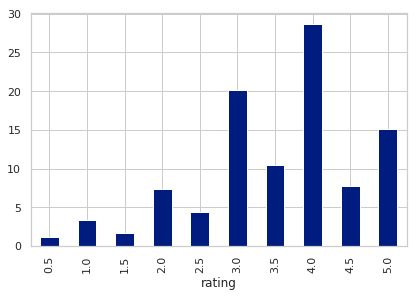

In [11]:
count_rates = rates.groupby('rating').count()
count_rates['perc_total']=round(count_rates['userId']*100/count_rates['userId'].sum(),1)
count_rates['perc_total'].plot.bar()

In [12]:
ratedmovies = pd.merge(rates, movies, on = 'movieId')
ratedmovies.tail()

,userId,movieId,rating,title,genres
99999,664,64997,2.5,War of the Worlds (2005),Action|Sci-Fi
100000,664,72380,3.5,"Box, The (2009)",Drama|Horror|Mystery|Sci-Fi|Thriller
100001,665,129,3.0,Pie in the Sky (1996),Comedy|Romance
100002,665,4736,1.0,Summer Catch (2001),Comedy|Drama|Romance
100003,668,6425,1.0,"6th Man, The (Sixth Man, The) (1997)",Comedy


##  Genres Distribution: 

In [13]:
# Create a function to find genres in the dataset
genres = {}
def find_genres():
  for genre in movies['genres']:
    words = genre.split('|')
    for word in words:
      genres[word] = genres.get(word, 0) + 1
            
find_genres()
genres['None'] = genres.pop('(no genres listed)')
listofgenres = list(genres.keys())
genres

{'Action': 1545,
 'Adventure': 1117,
 'Animation': 447,
 'Children': 583,
 'Comedy': 3315,
 'Crime': 1100,
 'Documentary': 495,
 'Drama': 4365,
 'Fantasy': 654,
 'Film-Noir': 133,
 'Horror': 877,
 'IMAX': 153,
 'Musical': 394,
 'Mystery': 543,
 'None': 18,
 'Romance': 1545,
 'Sci-Fi': 792,
 'Thriller': 1729,
 'War': 367,
 'Western': 168}

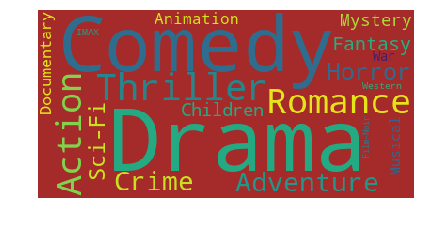

In [14]:
wordcloud = WordCloud(width=400, height=200, background_color = 'brown', min_font_size=7).generate_from_frequencies(genres)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Movies table with genres in one hot format

In [15]:
# GENRES = movies['genres']
MoviesWithGenres = movies.copy()
for genre in listofgenres :
  MoviesWithGenres[genre] = MoviesWithGenres.apply(lambda _:int(genre in _.genres), axis = 1)
MoviesWithGenres.head()

,movieId,title,genres,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,Documentary,IMAX,War,Musical,Western,Film-Noir,None
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## List of top scored movies over the whole range of movies, Using Weighted_Score

In [16]:
avg_movie_rating = pd.DataFrame(rates.groupby('movieId')['rating'].agg(['mean','count']))
avg_movie_rating['movieId']= avg_movie_rating.index
avg_rating_all= rates['rating'].mean()
min_reviews=20
movie_score = avg_movie_rating.loc[avg_movie_rating['count']>min_reviews]
movie_score.index.name = None

def weighted_rating(x, m=min_reviews, C=avg_rating_all):
  v = x['count']
  R = x['mean']
  # Calculation based on the IMDB formula
  return (v/(v+m) * R) + (m/(m+v) * C)

movie_score['weighted_score'] = movie_score.apply(weighted_rating, axis=1)
# movie_score.head()
movie_score = pd.merge(movie_score,MoviesWithGenres,on='movieId')
# movie_score.head()
pd.DataFrame(movie_score.sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score','genres']][:10])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,title,count,mean,weighted_score,genres
118,"Shawshank Redemption, The (1994)",311,4.487138,4.430127,Crime|Drama
249,"Godfather, The (1972)",200,4.487500,4.401692,Crime|Drama
29,"Usual Suspects, The (1995)",201,4.370647,4.295802,Crime|Mystery|Thriller
366,"Godfather: Part II, The (1974)",135,4.385185,4.276595,Crime|Drama
182,Schindler's List (1993),244,4.303279,4.245728,Drama|War
109,Pulp Fiction (1994),324,4.256173,4.214745,Comedy|Crime|Drama|Thriller
208,Fargo (1996),224,4.256696,4.198247,Comedy|Crime|Drama|Thriller
264,"Maltese Falcon, The (1941)",62,4.387097,4.181368,Film-Noir|Mystery
742,American Beauty (1999),220,4.236364,4.178634,Drama|Romance
347,Star Wars: Episode V - The Empire Strikes Back...,234,4.232906,4.178631,Action|Adventure|Sci-Fi


## Getting top n movies per genre:

In [17]:
def best_by_genre(genre,top_n):
  return pd.DataFrame(movie_score.loc[(movie_score[genre]==1)].sort_values(['weighted_score'],ascending=False)[['title','count','mean','weighted_score']][:top_n])

best_by_genre('Drama',5)  
  

,title,count,mean,weighted_score
118,"Shawshank Redemption, The (1994)",311,4.487138,4.430127
249,"Godfather, The (1972)",200,4.487500,4.401692
366,"Godfather: Part II, The (1974)",135,4.385185,4.276595
182,Schindler's List (1993),244,4.303279,4.245728
109,Pulp Fiction (1994),324,4.256173,4.214745


## Heavily Rated Movies

In [18]:
df_n_ratings = pd.DataFrame(ratedmovies.groupby('title')['rating'].mean())
df_n_ratings['total ratings'] = pd.DataFrame(ratedmovies.groupby('title')['rating'].count())
df_n_ratings.rename(columns = {'rating': 'mean ratings'}, inplace=True)

df_n_ratings.sort_values('total ratings', ascending=False).head(10)

,mean ratings,total ratings
title,,
Forrest Gump (1994),4.054252,341
Pulp Fiction (1994),4.256173,324
"Shawshank Redemption, The (1994)",4.487138,311
"Silence of the Lambs, The (1991)",4.138158,304
Star Wars: Episode IV - A New Hope (1977),4.221649,291
Jurassic Park (1993),3.706204,274
"Matrix, The (1999)",4.183398,259
Toy Story (1995),3.872470,247
Schindler's List (1993),4.303279,244


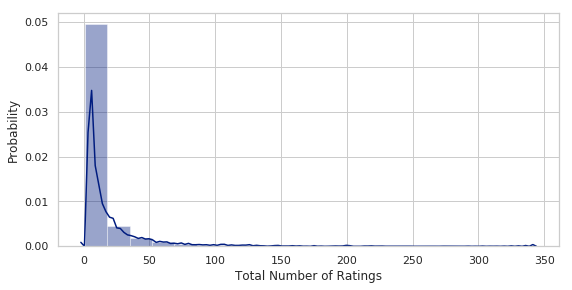

In [19]:
plt.figure(figsize=(8,4))
sns.distplot(df_n_ratings['total ratings'], bins=20)
plt.xlabel('Total Number of Ratings')
plt.ylabel('Probability')
plt.show()

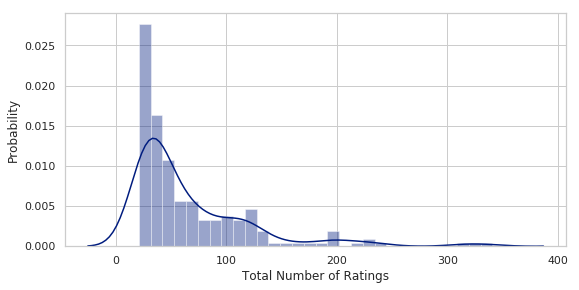

In [20]:
plt.figure(figsize=(8,4))
sns.distplot(best_by_genre('Drama',200)['count'], bins=30)
plt.xlabel('Total Number of Ratings')
plt.ylabel('Probability')
plt.show()

## Mean ratings vs Total number of ratings

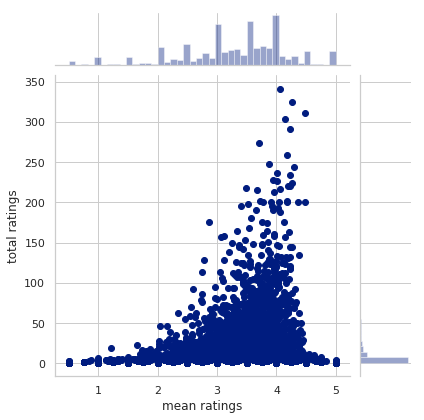

In [21]:
sns.jointplot(x = 'mean ratings', y = 'total ratings', data = df_n_ratings )

* Here, as the plot shows, every Data Point represents a single Movie.
* Also it is obvious that there is a huge density in the region corresponding to 0-50 number of users and between mean rating 3-4 .

# Content-Based Recommendation Model

In [22]:
# Break up the big genre string into a string array
moviesforcontent = movies.copy()
moviesforcontent['genres'] = moviesforcontent['genres'].str.split('|')
# Convert genres to string value
moviesforcontent['genres'] = moviesforcontent['genres'].fillna("").astype('str')
moviesforcontent.head()

,movieId,title,genres
0,1,Toy Story (1995),"['Adventure', 'Animation', 'Children', 'Comedy..."
1,2,Jumanji (1995),"['Adventure', 'Children', 'Fantasy']"
2,3,Grumpier Old Men (1995),"['Comedy', 'Romance']"
3,4,Waiting to Exhale (1995),"['Comedy', 'Drama', 'Romance']"
4,5,Father of the Bride Part II (1995),['Comedy']


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(moviesforcontent['genres'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
titles = movies['title']
indices = pd.Series(movies.index, index=movies['title'])

In [0]:
def genre_recommendations(title):
  idx = indices[title]
  sim_scores = list(enumerate(cosine_sim[idx]))
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
  sim_scores = sim_scores[1:21]
  movie_indices = [i[0] for i in sim_scores]
  return titles.iloc[movie_indices]

In [25]:
genre_recommendations('Walking Dead, The (1995)').head(10)

68                          Misérables, Les (1995)
188          Before the Rain (Pred dozhdot) (1994)
301                       Walking Dead, The (1995)
472                        Schindler's List (1993)
553    Land and Freedom (Tierra y libertad) (1995)
633                              Stalingrad (1993)
784                       A Walk in the Sun (1945)
881                                 Platoon (1986)
922       Tin Drum, The (Blechtrommel, Die) (1979)
937                          Paths of Glory (1957)
Name: title, dtype: object

# Collaborative Filtering (CF) Recommendation Model - Memory-based

## Item-based Collaborative Filtering

In [26]:
ratings_df = pd.pivot_table(rates, index='userId', columns='movieId', aggfunc=np.max)
ratings_df.head()

rating                              ...                                   
movieId 1      2      3      4      5       ... 161944 162376 162542 162672 163949
userId                                      ...                                   
1          NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
2          NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
3          NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
4          NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
5          NaN    NaN    4.0    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN

[5 rows x 9066 columns]

In [0]:
#Gets the other top 10 movies which are watched by the people who saw this particular movie
def get_other_movies(movie_name):
  #get all users who watched a specific movie
  df_movie_users_series = ratedmovies.loc[ratedmovies['title']==movie_name]['userId']
  df_movie_users = pd.DataFrame(df_movie_users_series,columns=['userId'])
  other_movies = pd.merge(df_movie_users,ratedmovies,on='userId')
  other_users_watched = pd.DataFrame(other_movies.groupby('title')['userId'].count()).sort_values('userId',ascending=False)
  other_users_watched['perc_who_watched'] = round(other_users_watched['userId']*100/other_users_watched['userId'][0],1)
  return other_users_watched[:10]

In [28]:
# Getting other top 10 movies which are watched by the people who saw 'Gone Girl'
get_other_movies('Fight Club (1999)')

,userId,perc_who_watched
title,,
Fight Club (1999),202,100.0
"Matrix, The (1999)",151,74.8
Pulp Fiction (1994),144,71.3
Forrest Gump (1994),138,68.3
"Shawshank Redemption, The (1994)",134,66.3
American Beauty (1999),130,64.4
"Silence of the Lambs, The (1991)",130,64.4
Star Wars: Episode IV - A New Hope (1977),128,63.4
"Lord of the Rings: The Fellowship of the Ring, The (2001)",128,63.4


In [29]:
#only include movies with more than 10 ratings
movie_plus_10_ratings = avg_movie_rating.loc[avg_movie_rating['count']>=10]
print('Number of movies which has more than 10 rates: ',len(movie_plus_10_ratings))
movie_plus_10_ratings.index.name = None
filtered_ratings = pd.merge(movie_plus_10_ratings, rates, on="movieId")
print('the number of records in new rates table: ',len(filtered_ratings))
filtered_ratings.head()

Number of movies which has more than 10 rates:  2245
the number of records in new rates table:  81915


,mean,count,movieId,userId,rating
0,3.87247,247,1,7,3.0
1,3.87247,247,1,9,4.0
2,3.87247,247,1,13,5.0
3,3.87247,247,1,15,2.0
4,3.87247,247,1,19,3.0


In [30]:
movie_wide = filtered_ratings.pivot(index = 'movieId', columns = 'userId', values = 'rating').fillna(0)
movie_wide.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0,2.0,0.0,0.0,0.0,3.0,3.5,0.0,0.0,3.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,5.0,4.0,0.0,4.0,0.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,4.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
model_knn = NearestNeighbors(metric='cosine',algorithm='brute', n_neighbors=6)
model_knn.fit(movie_wide)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                 radius=1.0)

In [0]:
#Gets the top 10 nearest neighbours got the movie
def print_similar_movies(movieid) :
  query_index_movie_ratings = movie_wide.loc[movieid,:].values.reshape(1,-1)
  distances,indices = model_knn.kneighbors(query_index_movie_ratings,n_neighbors = 11) 
  for i in range(0,len(distances.flatten())):
    get_movie = movies.loc[movies['movieId']==movieid]['title']
    if i==0:
      print('Recommendations for {0}:\n'.format(get_movie))
    else :
      indices_flat = indices.flatten()[i]
      get_movie = movies.loc[movies['movieId']==movie_wide.iloc[indices_flat,:].name]['title']
      print('{0}: {1}:'.format(i,get_movie))

In [33]:
print_similar_movies(50)

Recommendations for 48    Usual Suspects, The (1995)
Name: title, dtype: object:

1: 266    Pulp Fiction (1994)
Name: title, dtype: object:
2: 284    Shawshank Redemption, The (1994)
Name: title, dtype: object:
3: 45    Seven (a.k.a. Se7en) (1995)
Name: title, dtype: object:
4: 525    Silence of the Lambs, The (1991)
Name: title, dtype: object:
5: 969    Goodfellas (1990)
Name: title, dtype: object:
6: 535    Fargo (1996)
Name: title, dtype: object:
7: 472    Schindler's List (1993)
Name: title, dtype: object:
8: 880    Reservoir Dogs (1992)
Name: title, dtype: object:
9: 695    Godfather, The (1972)
Name: title, dtype: object:
10: 1288    L.A. Confidential (1997)
Name: title, dtype: object:


## User-based Collaborative Filtering

In [34]:
user_conf_matrix = ratings_df.copy()

# We will fill the row wise NaN's with the corresponding user's mean ratings, so that we can carry out Pearson correlation.
# Here we assume avg ratings for the movie that is not rated.
user_conf_matrix = user_conf_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)
user_conf_matrix.head(5)

rating                      ...                              
movieId    1         2         3       ...    162542    162672    163949
userId                                 ...                              
1        2.550000  2.550000  2.550000  ...  2.550000  2.550000  2.550000
2        3.486842  3.486842  3.486842  ...  3.486842  3.486842  3.486842
3        3.568627  3.568627  3.568627  ...  3.568627  3.568627  3.568627
4        4.348039  4.348039  4.348039  ...  4.348039  4.348039  4.348039
5        3.910000  3.910000  4.000000  ...  3.910000  3.910000  3.910000

[5 rows x 9066 columns]

In [35]:
user_corr_mat = user_conf_matrix.T.corr()
corrOfuser1 = user_corr_mat.iloc[0]
corrOfuser1.sort_values(ascending=False, inplace=True)
corrOfuser1.dropna(inplace = True)
top50_corr_users = corrOfuser1[1:51]

mylist = []
for i in range(100):
  if ratedmovies[ (ratedmovies['userId'] == 1) & (ratedmovies['movieId'] == i) ].empty:
    mylist.append(i)
  else:
    pass

print('{}nd Movie : '.format(mylist[3]), movies['title'][ movies['movieId'] == mylist[3] ].values)

top50_users = top50_corr_users.keys()

count = 0
users = list()
for user in top50_users:
  if ratedmovies[ (ratedmovies['userId'] == user) & (ratedmovies['movieId'] == mylist[3]) ]['rating'].sum()  :
    count +=1
    users.append(user)

def predict_rating():
  sum_similarity = 0
  weighted_ratings = 0
  for user in users:
    weighted_ratings += top50_corr_users.ix[user] * ratedmovies[ (ratedmovies['userId'] == user) & 
                                                          (ratedmovies['movieId'] == mylist[3]) ]['rating'].sum()
    sum_similarity += top50_corr_users.ix[user]

  return weighted_ratings / sum_similarity

print('the predicted rate for this movie by user 1 is: ',predict_rating())    
print("----------------------------------------------------------") 

3nd Movie :  ['Grumpier Old Men (1995)']
the predicted rate for this movie by user 1 is:  4.671299741451884
----------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


* As we saw in this example, we can predict the rate for movies which the user did not see and give a rate to them. so we can make our matrix factorization with this method then recommend the good movies to the user by predicted rate. in fact, predicted ratings are calculated similarly for every user, (obviously for the movies he's not rated) and depending upon the threshold rating, the movie is either displayed on his recommended list or discarded.

<a id="there_you_go_3"></a>
# Matrix Factorization using Deep Learning (Keras)

In [36]:
print('length of userid: ',len(ratedmovies.userId.unique())) 
print('length of movieid: ',len(ratedmovies.movieId.unique())) 
print('length of genres: ',len(ratedmovies.genres.unique()))

length of userid:  671
length of movieid:  9066
length of genres:  901


In [0]:
# Assigning a unique value to each user and movie in range 0,no_of_users and 0,no_of_movies and 0, no_of_genres respectively.
newratedmovies = ratedmovies.copy()
newratedmovies.userId = newratedmovies.userId.astype('category').cat.codes.values
newratedmovies.movieId = newratedmovies.movieId.astype('category').cat.codes.values
newratedmovies.genres = newratedmovies.genres.astype('category').cat.codes.values
train, test = train_test_split(newratedmovies, test_size=0.2)

In [38]:
train.head()

,userId,movieId,rating,title,genres
57485,211,3646,3.5,Planet of the Apes (2001),90
93780,563,3130,3.0,Hellraiser III: Hell on Earth (1992),859
4421,127,315,4.0,"Client, The (1994)",816
13470,383,232,4.5,Star Wars: Episode IV - A New Hope (1977),117
39630,472,7928,5.0,"Dark Knight Rises, The (2012)",77


In [39]:
test.head()

,userId,movieId,rating,title,genres
10975,561,1590,5.0,Saving Private Ryan (1998),270
75648,164,5022,1.5,Monster (2003),699
60370,387,4723,4.5,American Splendor (2003),623
87544,184,1958,2.0,Howard the Duck (1986),426
82845,198,6811,4.0,"Mist, The (2007)",869


In [40]:
print('train: ',train.shape)
print('test: ',test.shape)

train:  (80003, 5)
test:  (20001, 5)


In [0]:
n_users, n_movies, n_genres = len(newratedmovies.userId.unique()), len(newratedmovies.movieId.unique()), len(newratedmovies.genres.unique())

In [0]:
def matrix_factorisation_model_with_n_latent_factors(n_latent_factors, opt) :
  movie_input = keras.layers.Input(shape=(1,),name='Item',dtype='int64')
  movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding')(movie_input)
  movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

  user_input = keras.layers.Input(shape=(1,),name='User',dtype='int64')
  user_embedding = keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input)
  user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)
  
  prod = dot([movie_vec, user_vec],name='DotProduct', axes = 1)

  model = keras.Model([user_input, movie_input], prod)
  model.compile(optimizer = opt , loss = 'mean_squared_error')

  return model

In [44]:
import keras
batch_size=128
epochs=30
TESTUSER = 200
n_latent_factors = 10
optimizer = Adam()
model = matrix_factorisation_model_with_n_latent_factors(n_latent_factors, optimizer)

W0720 20:33:11.559002 140249737054080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0720 20:33:11.562875 140249737054080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0720 20:33:11.605760 140249737054080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0720 20:33:11.606955 140249737054080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 10)        90670       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 10)        6720        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

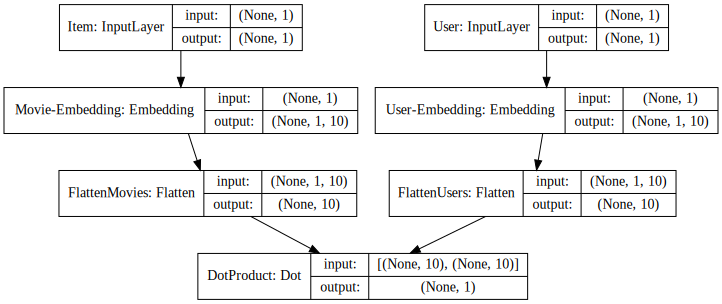

In [45]:
# SVG(model_to_dot(model).create(prog='dot', format='svg'))
model.summary()
SVG(model_to_dot( model,  show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [46]:
from IPython.display import clear_output

callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint('bestweights.h5', save_best_only=True)]

History = model.fit([train.userId,train.movieId],train.rating, batch_size=batch_size,
                              epochs =epochs, validation_data = ([test.userId,test.movieId],test.rating),
                              verbose = 1, callbacks=callbacks)
# clear_output()

W0720 20:33:19.715157 140249737054080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0720 20:33:19.788640 140249737054080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 80003 samples, validate on 20001 samples
Epoch 1/30
80003/80003 [==============================] - 5s 67us/step - loss: 13.4793 - val_loss: 12.4433
Epoch 2/30
80003/80003 [==============================] - 2s 25us/step - loss: 8.6970 - val_loss: 5.4870
Epoch 3/30
80003/80003 [==============================] - 2s 23us/step - loss: 3.8182 - val_loss: 3.1957
Epoch 4/30
80003/80003 [==============================] - 2s 23us/step - loss: 2.3691 - val_loss: 2.3768
Epoch 5/30
80003/80003 [==============================] - 2s 24us/step - loss: 1.7429 - val_loss: 1.9666
Epoch 6/30
80003/80003 [==============================] - 2s 24us/step - loss: 1.4023 - val_loss: 1.7274
Epoch 7/30
80003/80003 [==============================] - 2s 23us/step - loss: 1.1940 - val_loss: 1.5768
Epoch 8/30
80003/80003 [==============================] - 2s 24us/step - loss: 1.0557 - val_loss: 1.4767
Epoch 9/30
80003/80003 [==============================] - 2s 23us/step - loss: 0.9590 - val_loss: 1.4079
Epo

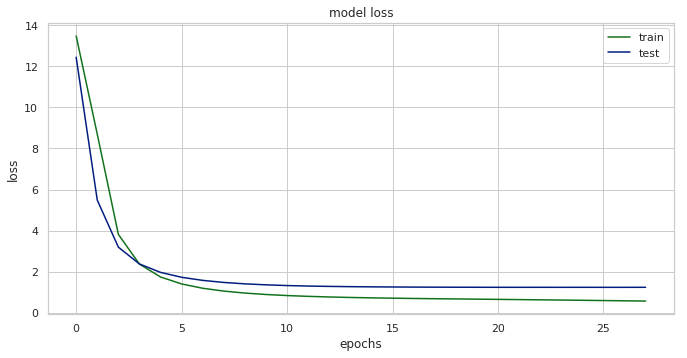

In [47]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(History.history['loss'] , 'g')
plt.plot(History.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.grid(True)
plt.show()

In [48]:
min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(History.history['val_loss']))
print ('Minimum RMSE at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(math.sqrt(min_val_loss)))

Minimum RMSE at epoch 26 = 1.1129


In [49]:
# Use the pre-trained model
model = matrix_factorisation_model_with_n_latent_factors(n_latent_factors, optimizer)
# Load weights
model.load_weights('bestweights.h5')

# Function to predict the ratings given User ID and Movie ID
def predict_rating(user_id, movie_id):
  return model.predict([np.array([user_id-1]), np.array([movie_id-1])])[0][0]

user_ratings = rates[rates['userId'] == TESTUSER][['userId', 'movieId', 'rating']]
user_ratings['prediction'] = user_ratings.apply(lambda x: predict_rating(TESTUSER, x['movieId']), axis=1)
user_ratings.sort_values(by='rating', 
                         ascending=False).merge(movies, 
                                                on='movieId', 
                                                how='inner', 
                                                suffixes=['_u', '_m']).head(20)

,userId,movieId,rating,prediction,title,genres
0,200,2571,5.0,3.764116,"Matrix, The (1999)",Action|Sci-Fi|Thriller
1,200,1682,5.0,2.157589,"Truman Show, The (1998)",Comedy|Drama|Sci-Fi
2,200,1270,5.0,3.174498,Back to the Future (1985),Adventure|Comedy|Sci-Fi
3,200,1625,5.0,3.800626,"Game, The (1997)",Drama|Mystery|Thriller
4,200,36529,5.0,0.000000,Lord of War (2005),Action|Crime|Drama|Thriller|War
5,200,87522,4.5,0.000000,Larry Crowne (2011),Comedy|Drama|Romance
6,200,3408,4.5,2.397418,Erin Brockovich (2000),Drama
7,200,4226,4.5,1.589128,Memento (2000),Mystery|Thriller
8,200,4223,4.5,2.765641,Enemy at the Gates (2001),Drama|War
9,200,4161,4.5,2.885487,"Mexican, The (2001)",Action|Comedy


In [50]:
recommendations = rates[rates['movieId'].isin(user_ratings['movieId']) == False][['movieId']].drop_duplicates()
recommendations['prediction'] = recommendations.apply(lambda x: predict_rating(TESTUSER, x['movieId']), axis=1)
recommendations.sort_values(by='prediction',
                          ascending=False).merge(movies,
                                                 on='movieId',
                                                 how='inner',
                                                 suffixes=['_u', '_m']).head(20)

,movieId,prediction,title,genres
0,1414,4.760458,Mother (1996),Comedy
1,3956,4.725616,Lost Souls (2000),Drama|Horror|Thriller
2,1245,4.693194,Miller's Crossing (1990),Crime|Drama|Film-Noir|Thriller
3,3612,4.689629,The Slipper and the Rose: The Story of Cindere...,Adventure|Children|Fantasy|Musical|Romance
4,3262,4.642327,Twin Peaks: Fire Walk with Me (1992),Crime|Drama|Mystery|Thriller
5,4053,4.632564,Double Take (2001),Action|Comedy
6,2434,4.609573,Down in the Delta (1998),Drama
7,8915,4.589152,Stage Beauty (2004),Drama
8,3153,4.582436,"7th Voyage of Sinbad, The (1958)",Action|Adventure|Fantasy
9,3560,4.552102,Empire of Passion (a.k.a. In the Realm of Pass...,Crime|Drama|Romance


In [0]:
def matrix_factorisation_model_with_n_latent_factors_and_deeper(n_latent_factors_user, n_latent_factors_movie) :
  
  movie_input = keras.layers.Input(shape=[1],name='Item')
  movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding')(movie_input)
  movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
  movie_vec = keras.layers.Dropout(0.2)(movie_vec)


  user_input = keras.layers.Input(shape=[1],name='User')
  user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
  user_vec = keras.layers.Dropout(0.2)(user_vec)


  concat = dot([movie_vec, user_vec], name='dot', axes=1)
  concat_dropout = keras.layers.Dropout(0.2)(concat)
  dense = keras.layers.Dense(100,name='FullyConnected')(concat)
  dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
  dense_2 = keras.layers.Dense(50,name='FullyConnected-1')(concat)
  dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
  dense_3 = keras.layers.Dense(20,name='FullyConnected-2')(dense_2)
  dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
  dense_4 = keras.layers.Dense(10,name='FullyConnected-3', activation='relu')(dense_3)


  result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
  adam = Adam(lr=0.005)
  model = keras.Model([user_input, movie_input], result)
  model.compile(optimizer=adam,loss= 'mean_absolute_error')
  return model

In [52]:
# batch_size=128
epochs=15
# TESTUSER = 200
n_latent_factors_user=5
n_latent_factors_movie=5
model = matrix_factorisation_model_with_n_latent_factors_and_deeper(n_latent_factors_user, n_latent_factors_movie)

W0720 20:34:24.570206 140249737054080 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 5)         45335       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         3360        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

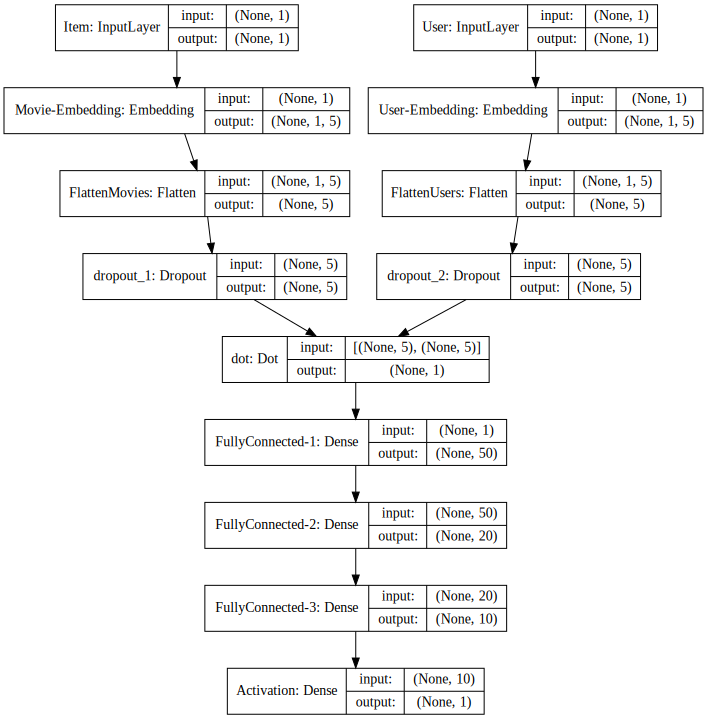

In [53]:
model.summary()
SVG(model_to_dot( model,  show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [54]:
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint('bestweightsdeeper.h5', save_best_only=True)]

History = model.fit([train.userId,train.movieId],train.rating, batch_size=batch_size,
                              epochs =epochs, validation_data = ([test.userId,test.movieId],test.rating),
                              verbose = 1, callbacks=callbacks)

Train on 80003 samples, validate on 20001 samples
Epoch 1/15
80003/80003 [==============================] - 4s 48us/step - loss: 0.9028 - val_loss: 0.8342
Epoch 2/15
80003/80003 [==============================] - 3s 36us/step - loss: 0.8451 - val_loss: 0.8364
Epoch 3/15
80003/80003 [==============================] - 3s 36us/step - loss: 0.8440 - val_loss: 0.8426


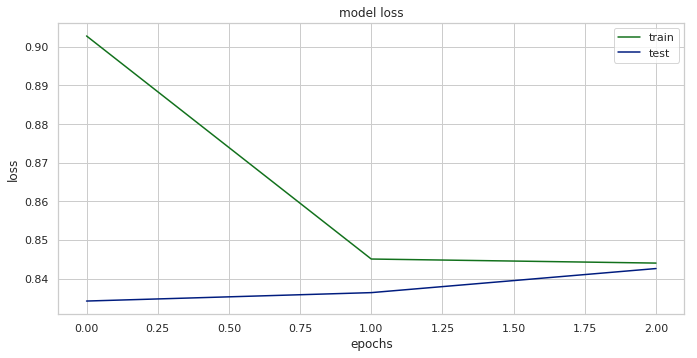

In [55]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(History.history['loss'] , 'g')
plt.plot(History.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.grid(True)
plt.show()

In [56]:
min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(History.history['val_loss']))
print ('Minimum RMSE at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(math.sqrt(min_val_loss)))

Minimum RMSE at epoch 1 = 0.9133


In [57]:
# Use the pre-trained model
model = matrix_factorisation_model_with_n_latent_factors_and_deeper(n_latent_factors_user, n_latent_factors_movie)
# Load weights
model.load_weights('bestweightsdeeper.h5')

# Function to predict the ratings given User ID and Movie ID
def predict_rating(user_id, movie_id):
  return model.predict([np.array([user_id-1]), np.array([movie_id-1])])[0][0]

user_ratings = rates[rates['userId'] == TESTUSER][['userId', 'movieId', 'rating']]
user_ratings['prediction'] = user_ratings.apply(lambda x: predict_rating(TESTUSER, x['movieId']), axis=1)
user_ratings.sort_values(by='rating', 
                         ascending=False).merge(movies, 
                                                on='movieId', 
                                                how='inner', 
                                                suffixes=['_u', '_m']).head(20)

,userId,movieId,rating,prediction,title,genres
0,200,2571,5.0,3.916101,"Matrix, The (1999)",Action|Sci-Fi|Thriller
1,200,1682,5.0,3.904038,"Truman Show, The (1998)",Comedy|Drama|Sci-Fi
2,200,1270,5.0,3.907216,Back to the Future (1985),Adventure|Comedy|Sci-Fi
3,200,1625,5.0,3.908276,"Game, The (1997)",Drama|Mystery|Thriller
4,200,36529,5.0,3.911752,Lord of War (2005),Action|Crime|Drama|Thriller|War
5,200,87522,4.5,3.911752,Larry Crowne (2011),Comedy|Drama|Romance
6,200,3408,4.5,3.902909,Erin Brockovich (2000),Drama
7,200,4226,4.5,3.914034,Memento (2000),Mystery|Thriller
8,200,4223,4.5,3.911232,Enemy at the Gates (2001),Drama|War
9,200,4161,4.5,3.913360,"Mexican, The (2001)",Action|Comedy


In [58]:
recommendations = rates[rates['movieId'].isin(user_ratings['movieId']) == False][['movieId']].drop_duplicates()
recommendations['prediction'] = recommendations.apply(lambda x: predict_rating(TESTUSER, x['movieId']), axis=1)
recommendations.sort_values(by='prediction',
                          ascending=False).merge(movies,
                                                 on='movieId',
                                                 how='inner',
                                                 suffixes=['_u', '_m']).head(20)

,movieId,prediction,title,genres
0,2219,3.929729,Murder! (1930),Mystery|Thriller
1,6877,3.928653,Girls Will Be Girls (2003),Comedy
2,1018,3.928262,That Darn Cat! (1965),Children|Comedy|Mystery
3,1032,3.927574,Alice in Wonderland (1951),Adventure|Animation|Children|Fantasy|Musical
4,2026,3.926853,Disturbing Behavior (1998),Horror|Thriller
5,1056,3.926444,Jude (1996),Drama
6,2294,3.925752,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy
7,1073,3.925659,Willy Wonka & the Chocolate Factory (1971),Children|Comedy|Fantasy|Musical
8,235,3.925420,Ed Wood (1994),Comedy|Drama
9,3460,3.925189,Hillbillys in a Haunted House (1967),Comedy


In [0]:
from keras import layers 
def matrix_factorisation_model_with_genres_and_n_latent_factors_and_deeper(n_latent_factors_user, n_latent_factors_movie, n_latent_factors_genre) :
  
  genre_input = keras.layers.Input(shape=[1],name='genre')
  genre_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors_genre, name='genre-Embedding')(genre_input)
  genre_vec = keras.layers.Flatten(name='Flattengenre')(genre_embedding)
  genre_vec = keras.layers.Dropout(0.2)(genre_vec)
  
  
  movie_input = keras.layers.Input(shape=[1],name='Item')
  movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding')(movie_input)
  movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
  movie_vec = keras.layers.Dropout(0.2)(movie_vec)


  user_input = keras.layers.Input(shape=[1],name='User')
  user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
  user_vec = keras.layers.Dropout(0.2)(user_vec)

  concat = layers.concatenate([genre_vec, user_vec, movie_vec], axis=1)
#   concat = dot([movie_vec, user_vec, genre_vec], name='dot', axes=1)
  concat_dropout = keras.layers.Dropout(0.2)(concat)
  dense = keras.layers.Dense(100,name='FullyConnected')(concat)
  dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
  dense_2 = keras.layers.Dense(50,name='FullyConnected-1')(concat)
  dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
  dense_3 = keras.layers.Dense(20,name='FullyConnected-2')(dense_2)
  dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
  dense_4 = keras.layers.Dense(10,name='FullyConnected-3', activation='relu')(dense_3)


  result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
  adam = Adam(lr=0.005)
  model = keras.Model([user_input, movie_input, genre_input], result)
  model.compile(optimizer=adam,loss= 'mean_absolute_error')
  return model

In [0]:
batch_size=128
epochs=10
TESTUSER = 200
n_latent_factors_user=5
n_latent_factors_movie=5
n_latent_factors_genre=3
model = matrix_factorisation_model_with_genres_and_n_latent_factors_and_deeper(n_latent_factors_user, n_latent_factors_movie, n_latent_factors_genre)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
genre (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
genre-Embedding (Embedding)     (None, 1, 3)         27201       genre[0][0]                      
__________________________________________________________________________________________________
User-Embed

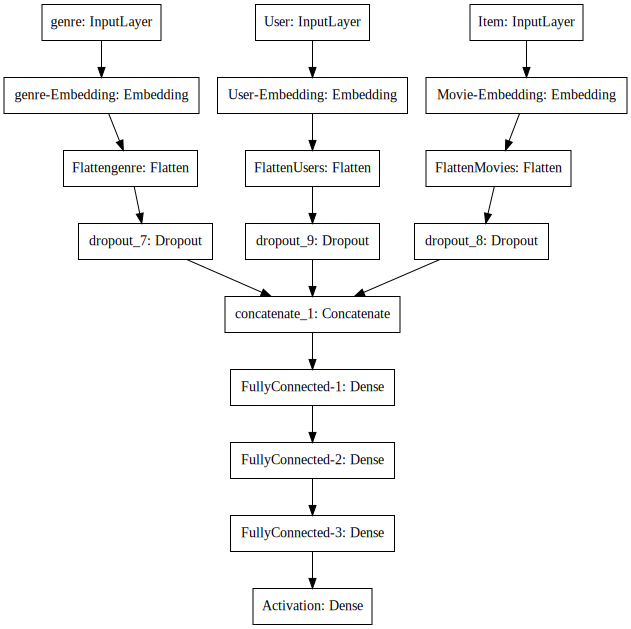

In [61]:
model.summary()
SVG(model_to_dot( model, show_layer_names=True).create(prog='dot', format='svg'))

In [62]:
callbacks = [EarlyStopping('val_loss', patience=5), 
             ModelCheckpoint('bestweightsdeeper&genre.h5', save_best_only=True)]

History = model.fit([train.userId,train.movieId, train.genres],train.rating, batch_size=batch_size,
                              epochs =epochs, validation_data = ([test.userId,test.movieId, test.genres],test.rating),
                              verbose = 1, callbacks=callbacks)

Train on 80003 samples, validate on 20001 samples
Epoch 1/10
80003/80003 [==============================] - 4s 46us/step - loss: 0.7761 - val_loss: 0.6920
Epoch 2/10
80003/80003 [==============================] - 3s 38us/step - loss: 0.6836 - val_loss: 0.7306
Epoch 3/10
80003/80003 [==============================] - 3s 39us/step - loss: 0.6664 - val_loss: 0.6914
Epoch 4/10
80003/80003 [==============================] - 3s 39us/step - loss: 0.6561 - val_loss: 0.6927
Epoch 5/10
80003/80003 [==============================] - 3s 39us/step - loss: 0.6479 - val_loss: 0.6821
Epoch 6/10
80003/80003 [==============================] - 3s 38us/step - loss: 0.6413 - val_loss: 0.6789
Epoch 7/10
80003/80003 [==============================] - 3s 39us/step - loss: 0.6351 - val_loss: 0.6773
Epoch 8/10
80003/80003 [==============================] - 3s 39us/step - loss: 0.6308 - val_loss: 0.6784
Epoch 9/10
80003/80003 [==============================] - 3s 39us/step - loss: 0.6284 - val_loss: 0.6769
Epoch

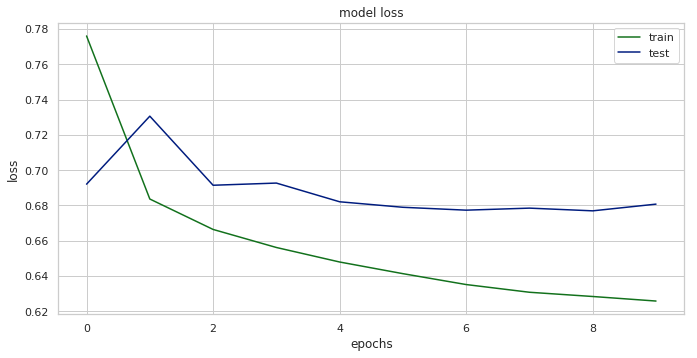

In [63]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(History.history['loss'] , 'g')
plt.plot(History.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.grid(True)
plt.show()

In [64]:
min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(History.history['val_loss']))
print ('Minimum RMSE at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(math.sqrt(min_val_loss)))

Minimum RMSE at epoch 9 = 0.8227
